# Convolutional Neural Networks

## Project: To Write an Algorithm for a Dog Identification App 

---




---
<a id='step0'></a>
## Step 0: Import Datasets



In [ ]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


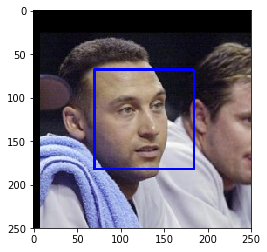

In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector


Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [ ]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def face_detection_test(files):
    detection_cnt = 0;
    total_cnt = len(files)
    for file in files:
        detection_cnt += face_detector(file)
    return detection_cnt, total_cnt

In [ ]:
print("detect face in human_files: {} / {}".format(face_detection_test(human_files_short)[0], face_detection_test(human_files_short)[1]))
print("detect face in dog_files: {} / {}".format(face_detection_test(dog_files_short)[0], face_detection_test(dog_files_short)[1]))

detect face in human_files: 99 / 100
detect face in dog_files: 11 / 100


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I used a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [ ]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("cuda available? {0}".format(use_cuda))

cuda available? True


In [ ]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, i wrote a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    # resize to (244, 244) because VGG16 accept this shape
    in_transform = transforms.Compose([
                        transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()]) # normalizaiton parameters from pytorch doc.

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = load_image(img_path)
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img)
    return torch.max(ret,1)[1].item() # predicted class index

In [ ]:
# predict dog using ImageNet class
VGG16_predict(dog_files_short[0])

153

### (IMPLEMENTATION) Write a Dog Detector



In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    idx = VGG16_predict(img_path)
    return idx >= 151 and idx <= 268 # true/false

In [ ]:
print(dog_detector(dog_files_short[0]))
print(dog_detector(human_files_short[0]))

True
False


### (IMPLEMENTATION) Assess the Dog Detector

__

__Answer:__ 


In [ ]:
.
def dog_detector_test(files):
    detection_cnt = 0;
    total_cnt = len(files)
    for file in files:
        detection_cnt += dog_detector(file)
    return detection_cnt, total_cnt

In [ ]:
print("detect a dog in human_files: {} / {}".format(dog_detector_test(human_files_short)[0], dog_detector_test(human_files_short)[1]))
print("detect a dog in dog_files: {} / {}".format(dog_detector_test(dog_files_short)[0], dog_detector_test(dog_files_short)[1]))

detect a dog in human_files: 0 / 100
detect a dog in dog_files: 92 / 100


In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.



---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)



## Preprocessing

In [ ]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 20
num_workers = 0

data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

## User Standard Normalization Value

In [ ]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

In [ ]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

## Use ImageFolder to Load image_dataset

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_classes = 133 # total classes of dog breeds

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


### (IMPLEMENTATION) Specify Loss Function and Optimizer



In [ ]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model



In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'saved_models/model_scratch.pt')

Epoch 1, Batch 1 loss: 3.641031
Epoch 1, Batch 101 loss: 3.628801
Epoch 1, Batch 201 loss: 3.622891
Epoch 1, Batch 301 loss: 3.669880
Epoch: 1 	Training Loss: 3.683353 	Validation Loss: 3.576741
Validation loss decreased (inf --> 3.576741).  Saving model ...
Epoch 2, Batch 1 loss: 3.568180
Epoch 2, Batch 101 loss: 3.609486
Epoch 2, Batch 201 loss: 3.618503
Epoch 2, Batch 301 loss: 3.632377
Epoch: 2 	Training Loss: 3.629078 	Validation Loss: 3.605958
Epoch 3, Batch 1 loss: 3.203771
Epoch 3, Batch 101 loss: 3.540342
Epoch 3, Batch 201 loss: 3.578337
Epoch 3, Batch 301 loss: 3.597487
Epoch: 3 	Training Loss: 3.596016 	Validation Loss: 3.474134
Validation loss decreased (3.576741 --> 3.474134).  Saving model ...
Epoch 4, Batch 1 loss: 3.474186
Epoch 4, Batch 101 loss: 3.588215
Epoch 4, Batch 201 loss: 3.572866
Epoch 4, Batch 301 loss: 3.571715
Epoch: 4 	Training Loss: 3.574707 	Validation Loss: 3.470782
Validation loss decreased (3.474134 --> 3.470782).  Saving model ...
Epoch 5, Batch 1 l

In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('saved_models/model_scratch.pt'))

### (IMPLEMENTATION) Test the Model



In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.511650


Test Accuracy: 16% (139/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)



### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset



In [ ]:

loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture



In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [ ]:
for param in model_transfer.parameters():
    param.requires_grad = False

In [ ]:
model_transfer.fc = nn.Linear(2048, 133, bias=True)

In [ ]:
fc_parameters = model_transfer.fc.parameters()

In [ ]:
for param in fc_parameters:
    param.requires_grad = True

In [ ]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
if use_cuda:
    model_transfer = model_transfer.cuda()

### (IMPLEMENTATION) Specify Loss Function and Optimizer


In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model



In [ ]:
# train the model
# train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [ ]:
train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'saved_models/model_transfer.pt')

Epoch 1, Batch 1 loss: 1.617044
Epoch 1, Batch 101 loss: 1.574596
Epoch 1, Batch 201 loss: 1.552519
Epoch 1, Batch 301 loss: 1.558110
Epoch: 1 	Training Loss: 1.563468 	Validation Loss: 0.979481
Validation loss decreased (inf --> 0.979481).  Saving model ...
Epoch 2, Batch 1 loss: 1.494852
Epoch 2, Batch 101 loss: 1.547349
Epoch 2, Batch 201 loss: 1.570372
Epoch 2, Batch 301 loss: 1.567318
Epoch: 2 	Training Loss: 1.561546 	Validation Loss: 0.953334
Validation loss decreased (0.979481 --> 0.953334).  Saving model ...
Epoch 3, Batch 1 loss: 1.460723
Epoch 3, Batch 101 loss: 1.510551
Epoch 3, Batch 201 loss: 1.511061
Epoch 3, Batch 301 loss: 1.519802
Epoch: 3 	Training Loss: 1.521592 	Validation Loss: 0.945071
Validation loss decreased (0.953334 --> 0.945071).  Saving model ...
Epoch 4, Batch 1 loss: 1.697795
Epoch 4, Batch 101 loss: 1.485003
Epoch 4, Batch 201 loss: 1.494420
Epoch 4, Batch 301 loss: 1.508853
Epoch: 4 	Training Loss: 1.512508 	Validation Loss: 0.933152
Validation loss de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('saved_models/model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.826528


Test Accuracy: 81% (681/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model


In [ ]:

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

In [ ]:
loaders_transfer['train'].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [ ]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [ ]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: ./images/Welsh_springer_spaniel_08203.jpg, 	 predition breed: Welsh springer spaniel
image_file_name: ./images/sample_dog_output.png, 	 predition breed: Great dane
image_file_name: ./images/Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
image_file_name: ./images/Labrador_retriever_06455.jpg, 	 predition breed: Labrador retriever
image_file_name: ./images/Brittany_02625.jpg, 	 predition breed: Brittany
image_file_name: ./images/Labrador_retriever_06449.jpg, 	 predition breed: Flat-coated retriever
image_file_name: ./images/sample_cnn.png, 	 predition breed: Chihuahua
image_file_name: ./images/Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images/American_water_spaniel_00648.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images/sample_human_output.png, 	 predition breed: Chihuahua


---
<a id='step5'></a>
## Step 5: Write your Algorithm


In [ ]:


def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Dogs Detected!\nIt looks like a {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
    else:
        print("Error! Can't detect anything..")

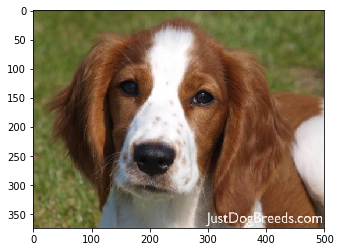

Dogs Detected!
It looks like a Welsh springer spaniel


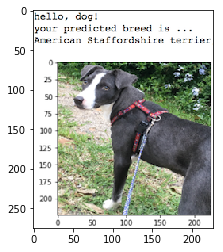

Dogs Detected!
It looks like a Great dane


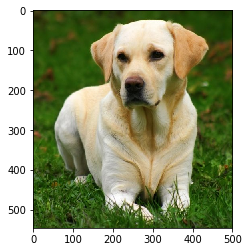

Dogs Detected!
It looks like a Labrador retriever


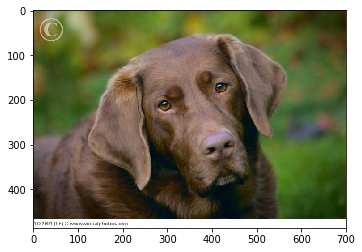

Dogs Detected!
It looks like a Labrador retriever


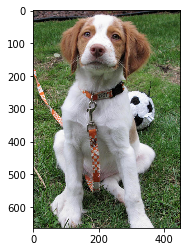

Dogs Detected!
It looks like a Brittany


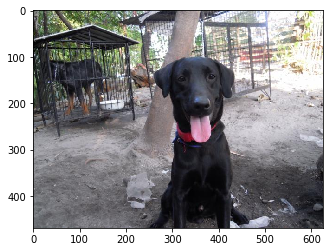

Dogs Detected!
It looks like a Flat-coated retriever


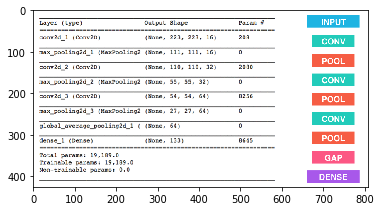

Error! Can't detect anything..


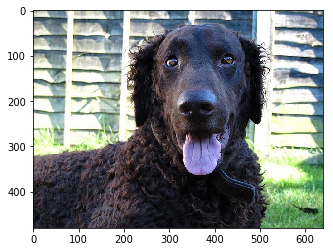

Dogs Detected!
It looks like a Curly-coated retriever


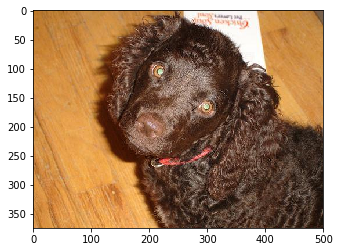

Dogs Detected!
It looks like a Curly-coated retriever


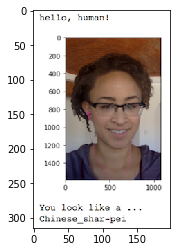

Hello, human!
If you were a dog..You may look like a Chihuahua


In [ ]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Testing Algorithm


In [ ]:
my_human_files = ['./my_images/human_1.jpg', './my_images/human_2.jpg', './my_images/human_3.jpg' ]
my_dog_files = ['./my_images/dog_shiba.jpeg', './my_images/dog_yorkshire.jpg', './my_images/dog_retreiver.jpg']

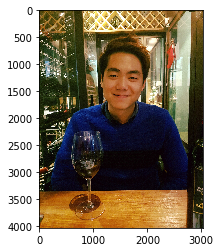

Hello, human!
If you were a dog..You may look like a Finnish spitz


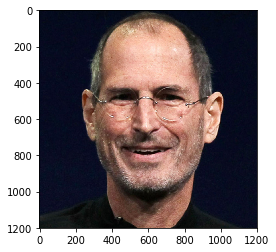

Hello, human!
If you were a dog..You may look like a Bull terrier


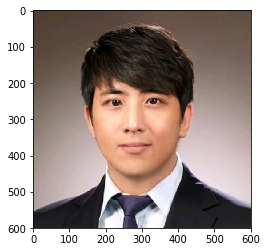

Hello, human!
If you were a dog..You may look like a Norwich terrier


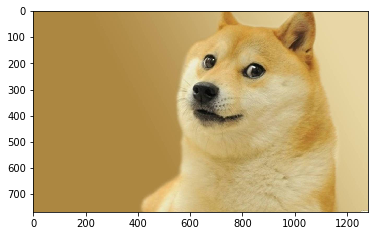

Dogs Detected!
It looks like a Canaan dog


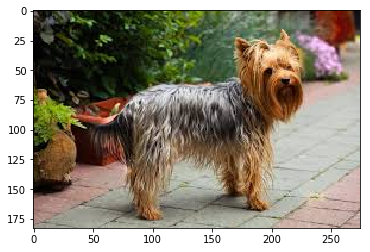

Dogs Detected!
It looks like a Silky terrier


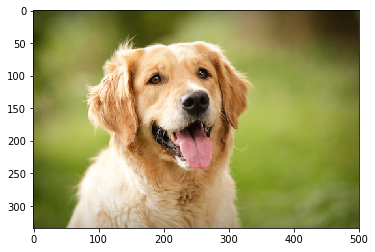

Dogs Detected!
It looks like a Golden retriever


In [ ]:

for file in np.hstack((my_human_files, my_dog_files)):
    run_app(file)